In [1]:
import re
import nltk
import string
import fasttext
from nltk import wordnet
from nltk.corpus import stopwords


import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dense, Input, Flatten
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [3]:
df = pd.read_csv(r"IMDB Dataset.csv")


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
data = df.sample(n=20000)

In [6]:
def actual_tag(string):
    if string.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif string.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif string.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif string.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

In [7]:
def lemmatize(array):
    opt_list = []
    wl = nltk.WordNetLemmatizer()
    stop = stopwords.words('english')
    stop += list(string.punctuation)
    for tple in array:
        word, tag = tple
        if word.lower() not in stop and word.isalpha():
            temp = wl.lemmatize(word,actual_tag(tag))
            opt_list.append(temp.lower())
    return opt_list

In [8]:
def preprocess(text):
    text = nltk.tokenize.word_tokenize(text)
    text = nltk.pos_tag(text)
    text = lemmatize(text)
    return text

In [9]:
processed_data = data['review'].map(preprocess)

In [10]:
processed_data.head()

16004    [definitely, big, surprise, festival, far, wit...
48410    [one, reason, watch, movie, relate, one, star,...
9053     [sherman, set, wayback, machine, united, state...
45035    [really, want, like, film, second, film, serie...
37911    [well, pop, dvd, waste, hour, half, life, neve...
Name: review, dtype: object

In [11]:
data['sentiment'].value_counts()

sentiment
positive    10073
negative     9927
Name: count, dtype: int64

In [12]:
# Tokenization
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(processed_data)
sequences = tokenizer.texts_to_sequences(processed_data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 59110 unique tokens.


In [13]:
data.loc[data['sentiment'] == 'positive','sentiment'] = 1
data.loc[data['sentiment'] == 'negative','sentiment'] = 0
labels = np.asarray(data['sentiment']).astype(np.float32)
labels

array([1., 0., 1., ..., 1., 1., 1.], dtype=float32)

In [14]:
features = pad_sequences(sequences, MAX_SEQUENCE_LENGTH)

features.shape, labels.shape

((20000, 100), (20000,))

In [15]:
x_train, x_test, y_train, y_test = train_test_split( features, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( features, labels, test_size=0.50, random_state=4)
x_train.shape, y_train.shape

((16000, 100), (16000,))

In [16]:
embedding_model = fasttext.load_model(r"fasttext_embedding_model.bin")

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_model.get_word_vector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

In [17]:

convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(128,fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)   
l_merge = Concatenate()(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
# l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
# l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(1, activation='sigmoid')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             5911100   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 98, 128)              38528     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 97, 128)              51328     ['embedding[0][0]']           
                                                                                              

In [18]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=15, batch_size=150, verbose=1)

Epoch 1/15
107/107 [==============================] - 25s 216ms/step - loss: 0.4938 - acc: 0.7427 - val_loss: 0.3207 - val_acc: 0.8641
Epoch 2/15
107/107 [==============================] - 32s 296ms/step - loss: 0.2672 - acc: 0.8903 - val_loss: 0.1907 - val_acc: 0.9318
Epoch 3/15
107/107 [==============================] - 38s 358ms/step - loss: 0.1717 - acc: 0.9335 - val_loss: 0.1323 - val_acc: 0.9560
Epoch 4/15
107/107 [==============================] - 39s 361ms/step - loss: 0.0828 - acc: 0.9725 - val_loss: 0.1114 - val_acc: 0.9655
Epoch 5/15
107/107 [==============================] - 26s 240ms/step - loss: 0.0235 - acc: 0.9948 - val_loss: 0.1229 - val_acc: 0.9704
Epoch 6/15
107/107 [==============================] - 23s 213ms/step - loss: 0.0059 - acc: 0.9992 - val_loss: 0.1189 - val_acc: 0.9733
Epoch 7/15
107/107 [==============================] - 25s 231ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.1365 - val_acc: 0.9732
Epoch 8/15
107/107 [==============================] - 2

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


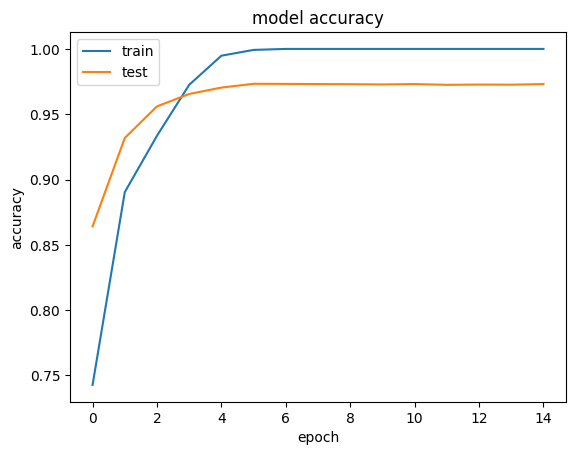

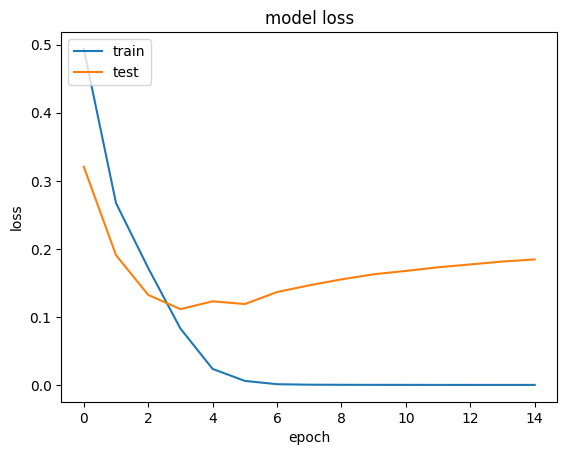

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
y_pred = model.predict(x_test, verbose = 1)

313/313 [==============================] - 4s 12ms/step


In [21]:
y_pred

array([[1.0000000e+00],
       [4.6812693e-07],
       [9.9999958e-01],
       ...,
       [2.1481385e-07],
       [9.9999511e-01],
       [5.3408597e-02]], dtype=float32)

In [22]:
def fx(num):
    if num >= 0.5:
        return 1
    else:
        return 0

arr = np.asarray(list(map(fx,y_pred)))
ans = np.asarray(y_test)

In [32]:
f1 = f1_score(arr,ans, zero_division=1.0,average='micro')
r1 = recall_score(arr,ans, zero_division=1.0,average='micro')
p1 = precision_score(arr,ans, zero_division=1.0,average='micro')
acc = accuracy_score(arr,ans)
print('f1',f1)
print('recall',r1)
print('precision',p1)
print('acc',acc)

f1 0.9723
recall 0.9723
precision 0.9723
acc 0.9723


In [27]:
cm = confusion_matrix(arr, ans)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(arr)))
# disp.plot()
# plt.title("Confusion matrix")
# plt.show()
cm

array([[4839,  129],
       [ 148, 4884]], dtype=int64)

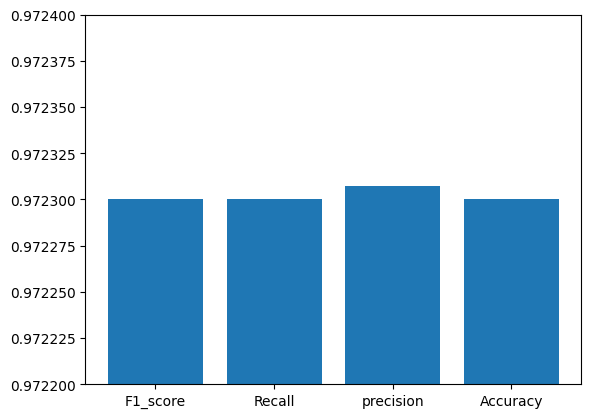

In [31]:
x = np.array(["F1_score", "Recall", "precision", "Accuracy"])
y = np.array([f1, r1, p1, acc])


plt.bar(x,y)
plt.ylim(.9722,.9724)
plt.show()